In [1]:
# import libaries for data science and machine learning
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")#, category=DeprecationWarning)


In [2]:
#!pip freeze > Github_requirements.txt
!conda --version

conda 4.8.3


## Loading TPMS dataset

In [3]:
# Load the TPMS dataset into dataframe for dispersion curves
combined_TPMS_df = pd.read_csv('20240604 TPMS_data_github.csv') # the TPMS data added data (last update: 2024 06 04 )

# Reading 5 first rows of data and showing all features
combined_TPMS_df.head(5)

,k,BNF=1(kHz),BNF=2(kHz),BNF=3(kHz),BNF=4(kHz),BNF=5(kHz),BNF=6(kHz),BNF=7(kHz),BNF=8(kHz),BNF=9(kHz),...,ay(mm),az(mm),Band Type,TPMS type,Solid Material,Medium,Shell thickness,t,CBG,BG exists?
0,0.00,12.686044,12.686307,12.686353,14.065886,15.271969,15.272604,15.272682,22.946688,25.693271,...,20,20,Acoustic,Schwarz-P,Polymer,Air,Nan,-1.2,0.000263,no
1,0.05,12.638788,12.668705,12.668951,14.121445,15.271199,15.296990,15.297104,22.951694,25.649075,...,20,20,Acoustic,Schwarz-P,Polymer,Air,Nan,-1.2,0.000263,no
2,0.10,12.514459,12.618700,12.618934,14.269854,15.268643,15.368273,15.368379,22.966659,25.524732,...,20,20,Acoustic,Schwarz-P,Polymer,Air,Nan,-1.2,0.000263,no
3,0.15,12.346172,12.541410,12.541628,14.478354,15.264458,15.481023,15.481117,22.991428,25.340047,...,20,20,Acoustic,Schwarz-P,Polymer,Air,Nan,-1.2,0.000263,no
4,0.20,12.157726,12.443672,12.443871,14.723271,15.258759,15.628392,15.628476,23.025739,25.114085,...,20,20,Acoustic,Schwarz-P,Polymer,Air,Nan,-1.2,0.000263,no


## Acoustic Feature Extraction

In [4]:
#Drop Elastic data (extracting acoustic data only)
combined_TPMS_df= combined_TPMS_df[combined_TPMS_df['Band Type'] == 'Acoustic']


## Data Analysis: Ploting VF variation to Observe Acoustic Bandgaps (ABG)

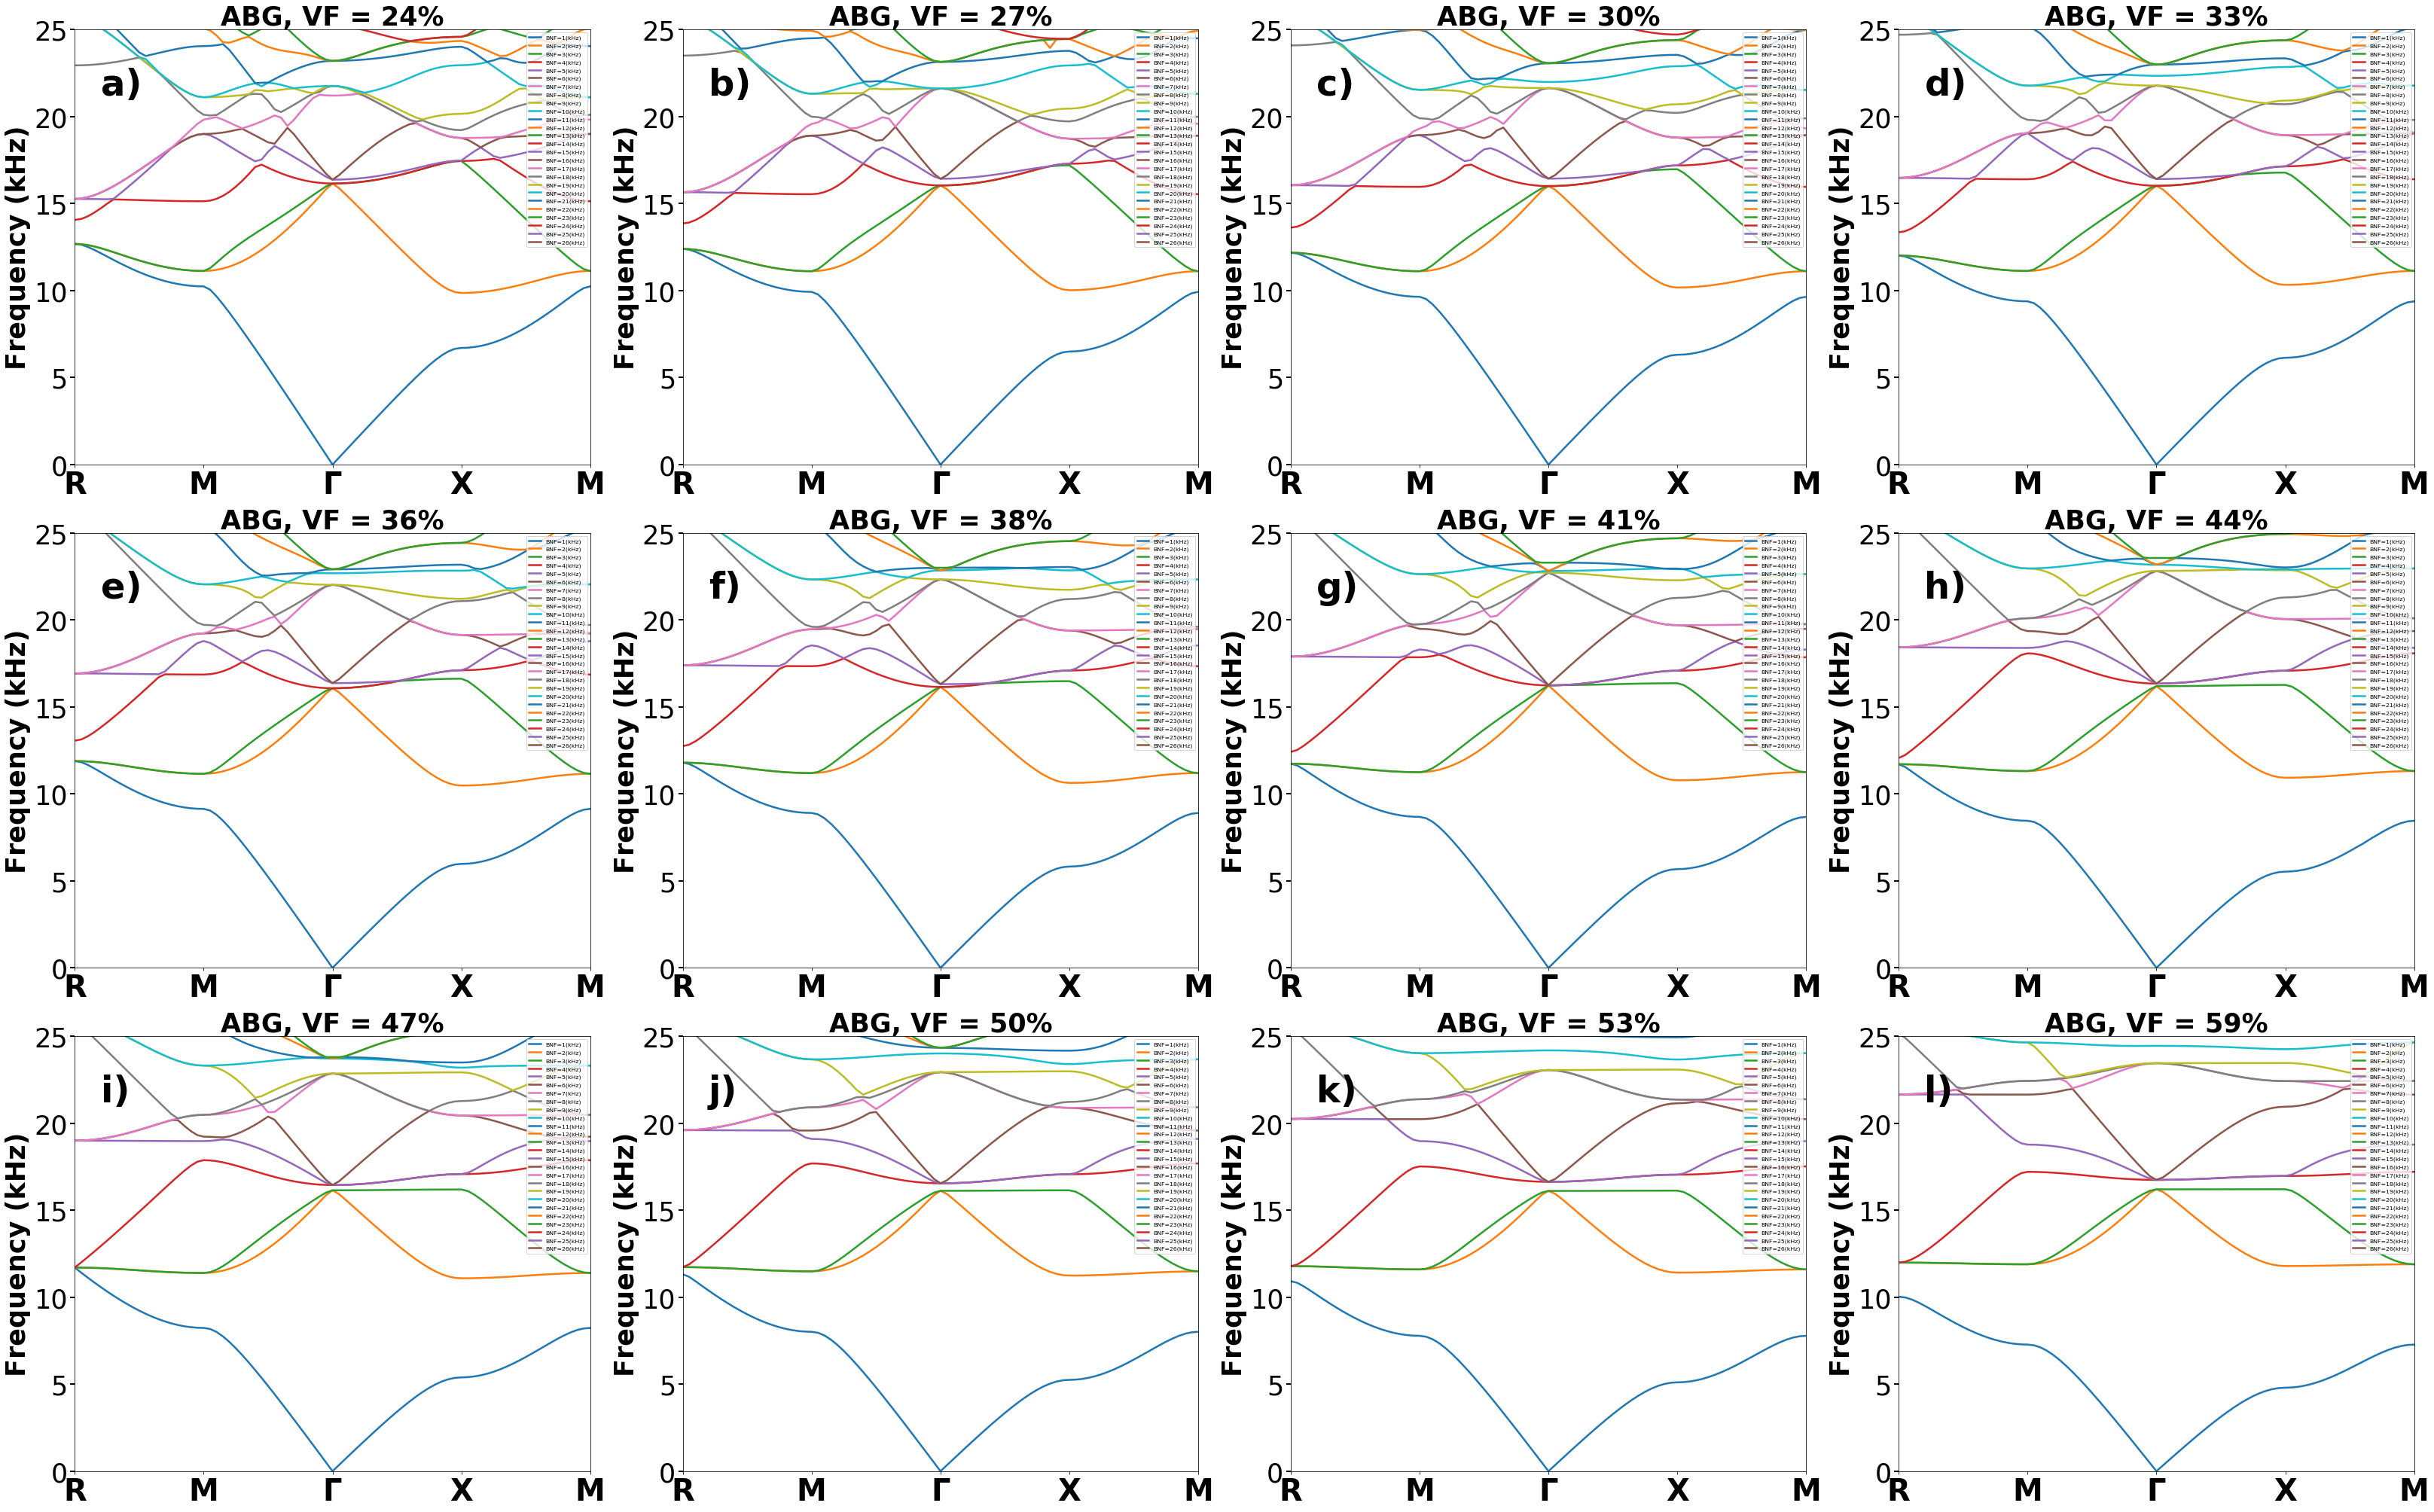

In [5]:
# Create subplots in a 5x4 grid with additional setup
fig, axs = plt.subplots(3, 4, figsize=(45, 28))

# Create a list of labels for subplot annotations
subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)' ]
ratios = [24, 27, 30, 33, 36, 38, 41, 44, 47, 50, 53, 59 ]  # Replace with your desired ratios

for i, ratio in enumerate(ratios):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    
    subset_df = combined_TPMS_df[combined_TPMS_df['VF(%)'] == ratio]
    #subset_df = subset_df[subset_df['Band Type'] == 'Acoustic']  # selecting Acoustic Band Strcture

    # Plot BNF columns against "k"
    for col in subset_df.columns:
        if col.startswith("BNF="):
            ax.plot(subset_df['k'], subset_df[col], label=col,linewidth=2.5)

    ax.set_title(f"ABG, VF = {ratio}%", fontsize=35,fontweight='bold')
    ax.set_xticks([0, 1, 2, 3, 4, 5])  # Define the positions of the ticks
    ax.set_xticklabels(['R', 'M', 'Γ', 'X', 'M'], fontsize=40,fontweight='bold')  # Set custom labels
    ax.set_ylabel("Frequency (kHz)", fontsize=35,fontweight='bold')
    ax.tick_params(axis='y', labelsize=35, width=2, length=6)  # Make y-axis ticks bigger and bolder
    ax.legend(loc='upper right', fontsize=7.8, )  # Move the legend to the upper right and set font size
    
    # Add additional setup
    ax.tick_params(axis='y', labelsize=35, width=2, length=6)  # Make y-axis ticks bigger and bolder
    ax.set_xlim([0, 4])  # Set x limits
    ax.set_ylim([0, 25])  # Set y limits

    # Annotate the figure with subplot labels
    subplot_label = subplot_labels[i]
    ax.annotate(subplot_label, xy=(0.05, 0.85), xycoords='axes fraction', fontsize=48, fontweight='bold')

# Add the subplots_adjust setup
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.tight_layout()
plt.show()

## Training  on limited features (MLP Machine Learning Model)

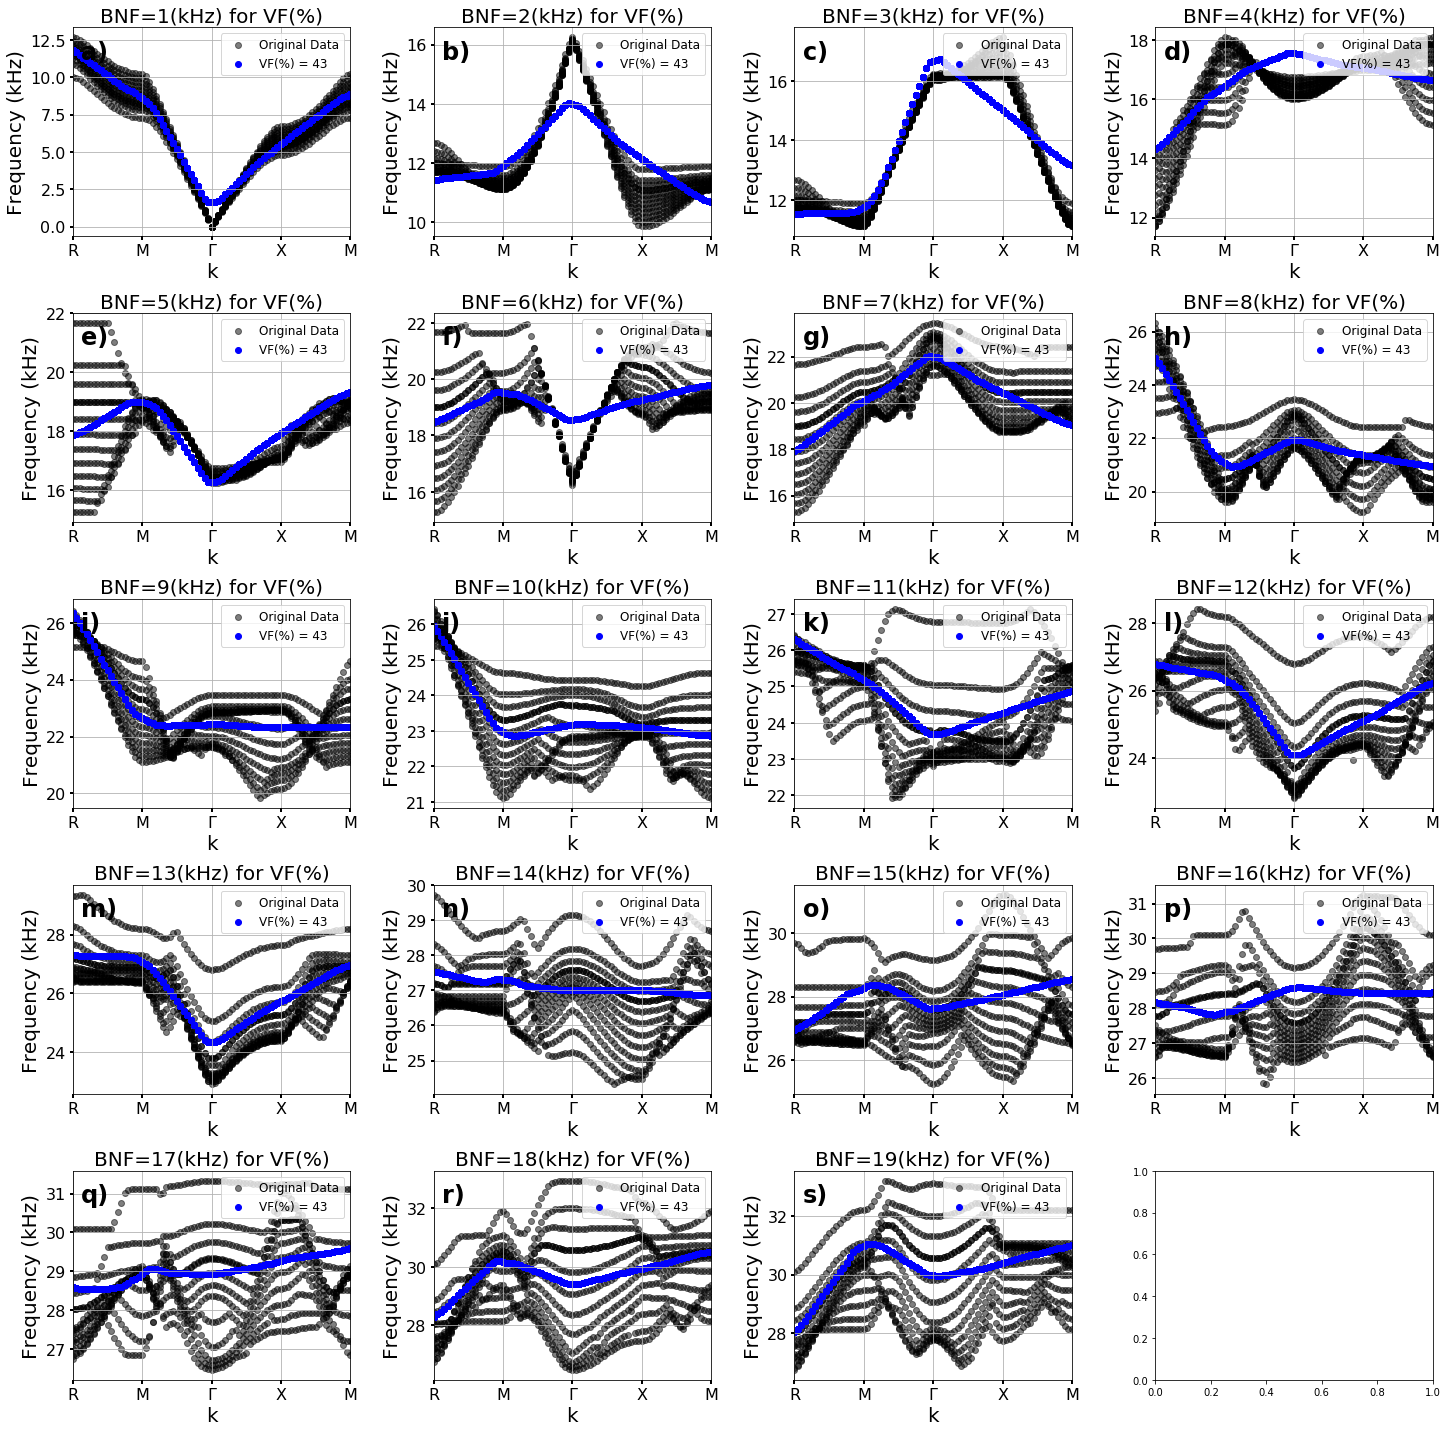

In [6]:
# Generate a random dataset with 5 features
df = combined_TPMS_df

# Generate a target variable with a sinusoidal pattern
k_values = df['k']

# Get the columns for BNF values from BNF=1 to BNF=19
bnf_columns = [f'BNF={i}(kHz)' for i in range(1, 20)]

# Separate the features (X) and target (y)
X = df[['k', 'VF(%)']]
y = df[bnf_columns]

# Get unique VF(%) values in the original data
unique_VF_values = df['VF(%)'].unique()

# Create a list to store trained models for each unique VF(%) value
trained_models = []

# Train models for each unique VF value and store them
for VF_value in unique_VF_values:
    # Create a copy of the original 'X' DataFrame
    X_copy = X.copy()
    
    # Set a constant value for 'VF(%)' in the copied DataFrame
    X_copy['VF(%)'] = VF_value

    # Create an MLPRegressor model with the same hyperparameters as provided
    #model = MLPRegressor(hidden_layer_sizes=(400, 300, 200, 100, 50), max_iter=5000, random_state=42)
    model= MLPRegressor(hidden_layer_sizes=(400, 300, 200, 100, 50), activation='relu', solver='adam', alpha=0.0001, max_iter=1000, random_state=42)

    # Train the model on the data
    model.fit(X_copy, y)
    
    # Append the trained model to the list
    trained_models.append(model)

# Define the arbitrary VF values for prediction
VF_values_arbitrary = [43]

# Initialize a Nearest Neighbors model
nn = NearestNeighbors(n_neighbors=2)  # We need 2 neighbors (higher and lower VF values)
nn.fit(np.array(unique_VF_values).reshape(-1, 1))

# Create subplots
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)

# Define labels for subplot indexing (a), b), c), etc.)
subplot_labels = [chr(ord('a') + i) for i in range(len(bnf_columns))]

for idx, bnf_column in enumerate(bnf_columns):
    row = idx // 4
    col = idx % 4

    # Lists to store the predictions for each VF value
    predicted_BNF_values = []

    # Iterate through each VF_value_arbitrary
    for VF_value_arbitrary in VF_values_arbitrary:
        # Find the nearest trained VF values (higher and lower)
        _, nearest_indices = nn.kneighbors(np.array(VF_value_arbitrary).reshape(1, -1))
        nearest_indices = nearest_indices[0]
        
        # Get the trained models for the nearest VF values
        lower_model = trained_models[nearest_indices[0]]
        higher_model = trained_models[nearest_indices[1]]
        
        # Calculate weights based on proximity to VF_value_arbitrary
        lower_VF = unique_VF_values[nearest_indices[0]]
        higher_VF = unique_VF_values[nearest_indices[1]]
        total_VF_range = higher_VF - lower_VF
        weight_lower = 1 - ((VF_value_arbitrary - lower_VF) / total_VF_range)
        weight_higher = 1 - weight_lower
        
        # Predict the BNF value for the varying 'k' values using both models
        k_values_2d = k_values.values.reshape(-1, 1)
        lower_predictions = lower_model.predict(np.hstack((k_values_2d, np.full_like(k_values_2d, VF_value_arbitrary))))
        higher_predictions = higher_model.predict(np.hstack((k_values_2d, np.full_like(k_values_2d, VF_value_arbitrary))))
        
        # Calculate weighted average predictions
        weighted_average_predictions = (weight_lower * lower_predictions) + (weight_higher * higher_predictions)
        
        # Append the weighted average predictions to the list
        predicted_BNF_values.append(weighted_average_predictions)
    
    # Plot original data for specific VF values [22, 30, 59] in black
    axs[row, col].scatter(k_values, y[f'BNF={idx+1}(kHz)'], label='Original Data', color='black', alpha=0.5)
    
    # Plot the predictions for VF values [22, 30, 59] in orange, green, and blue
    scatter_colors = ['blue', 'green', 'blue']
    for i, VF_value_arbitrary in enumerate(VF_values_arbitrary):
        axs[row, col].scatter(k_values, predicted_BNF_values[i][:, idx], label=f'VF(%) = {VF_value_arbitrary}', color=scatter_colors[i])

    axs[row, col].set_xlabel('k', fontsize=20)  # Adjust x-axis label fontsize
    axs[row, col].set_ylabel('Frequency (kHz)', fontsize=20)  # Adjust y-axis label fontsize

    # Set the x-axis limit from 0 to 4
    axs[row, col].set_xlim(0, 4)

    # Set the x-axis tick labels here
    ax = axs[row, col]
    ax.set_xticklabels([ 'R', 'M', 'Γ', 'X', 'M'], fontsize=20)

    # Modify the title label fontsize and weight
    axs[row, col].set_title(f'{bnf_column} for VF(%)', fontsize=20)
    
    # Adjust tick parameters (fontsize and thickness)
    axs[row, col].tick_params(axis='both', which='major', labelsize=16, width=2)
    
    axs[row, col].grid(True)
    axs[row, col].legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=12)
    
    # Add index label (a), b), c), etc.) inside each subplot (offset from top left)
    axs[row, col].text(0.03, 0.85, f'{subplot_labels[idx]})', transform=axs[row, col].transAxes, fontsize=24, fontweight='bold')

# Display the subplots
plt.tight_layout()
plt.show()

## Training on more features (MLP ML Model)

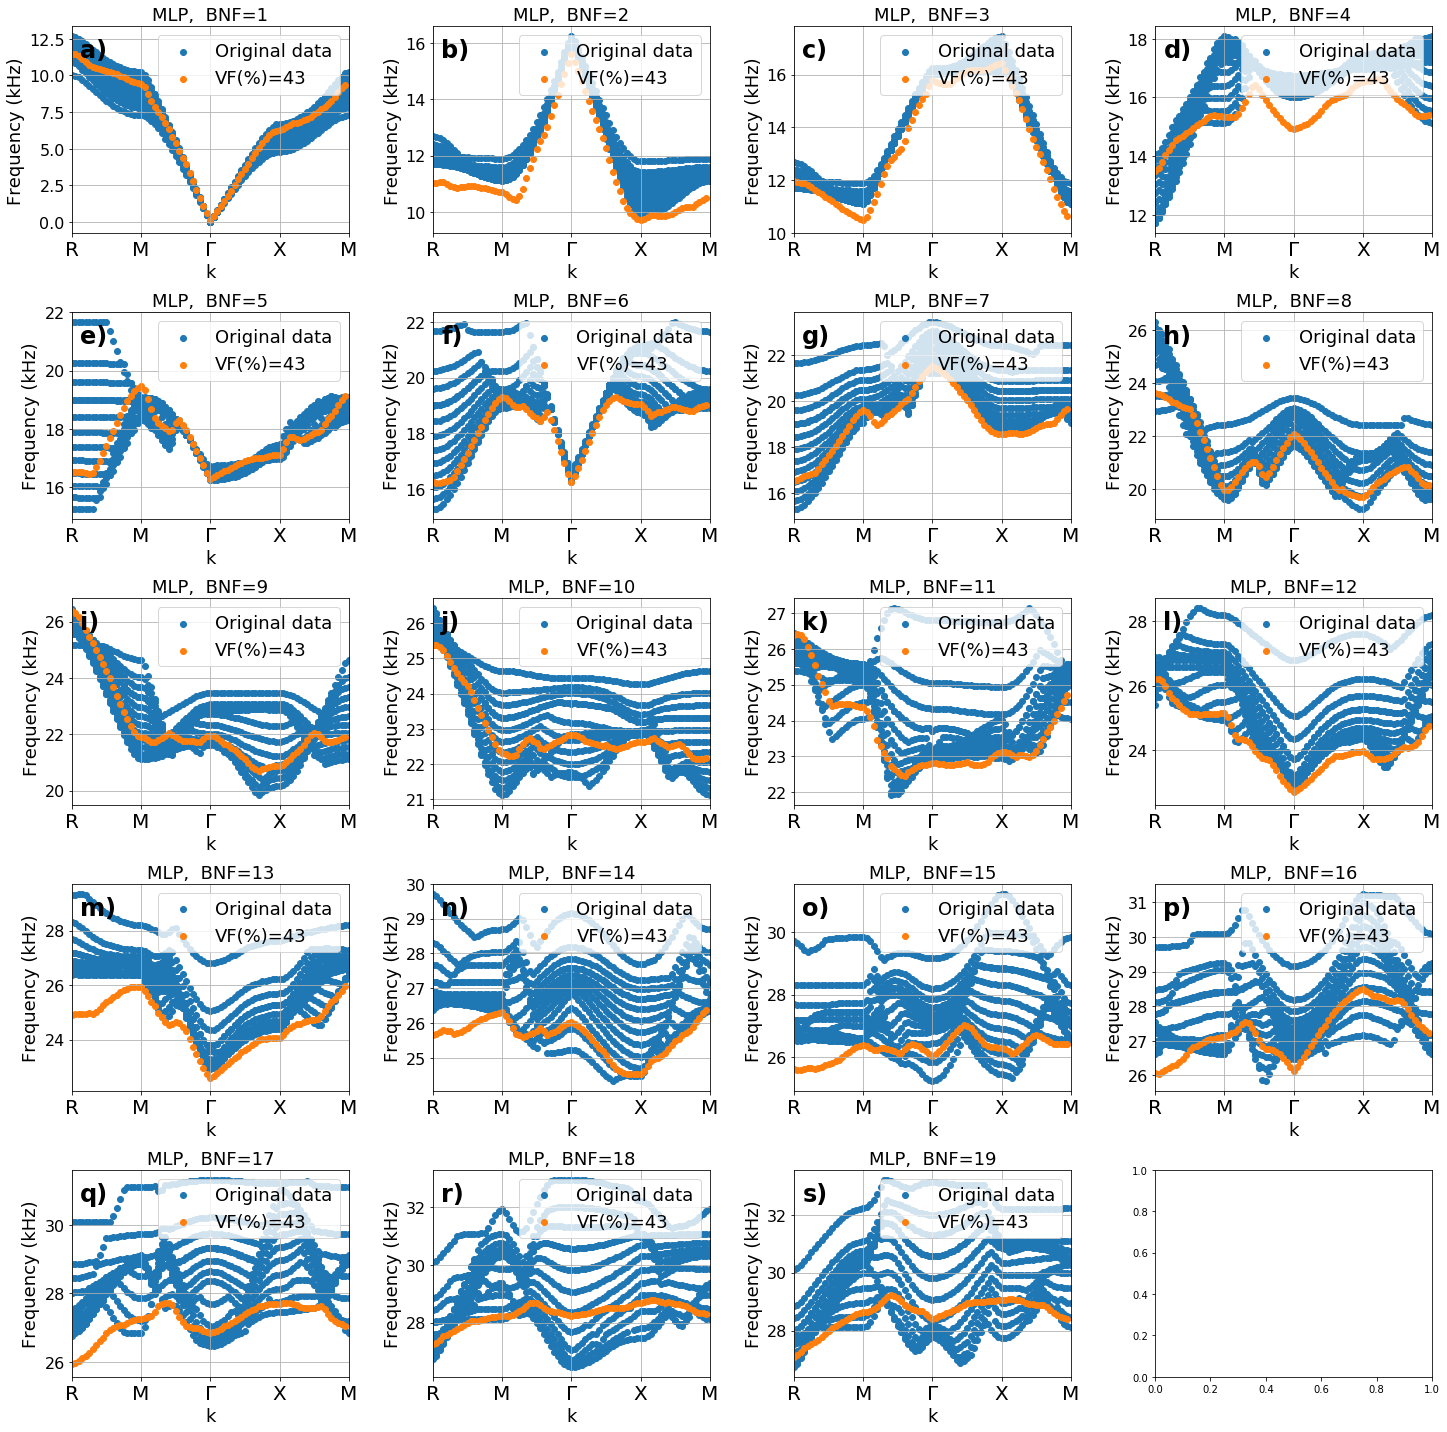

In [7]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# Load your data into a DataFrame
# df = pd.read_csv("your_data.csv")

# Define the BNF inputs (band numbers) chosen by the user
BNF_values = list(range(1, 20))  # Add the range of BNF values you want to calculate

# Define common features and settings
X = combined_TPMS_df[["k", "VF(%)", "BNF=1(kHz)", "BNF=2(kHz)", "BNF=3(kHz)", "BNF=4(kHz)", "BNF=5(kHz)", "BNF=6(kHz)",
        "BNF=7(kHz)", "BNF=8(kHz)", "BNF=9(kHz)", "BNF=10(kHz)", "BNF=11(kHz)",
        "BNF=12(kHz)", "BNF=13(kHz)", "BNF=14(kHz)", "BNF=15(kHz)", "BNF=16(kHz)",
        "BNF=17(kHz)", "BNF=18(kHz)", "BNF=19(kHz)", "BNF=20(kHz)"]
       ]
k_values = np.arange(0, 4.0, 0.05)
VF = 43

# Create a 5x4 subplot layout, where 5 is the number of rows and 4 is the number of columns
num_rows = 5
num_columns = 4

# Adjust the width of each subplot by setting the figsize
fig, axs = plt.subplots(num_rows, num_columns, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)

# Labels for subplot indexing (a), b), c), etc.
subplot_labels = [chr(ord('a') + i) for i in range(len(BNF_values))]

for i, BNF_value in enumerate(BNF_values):
    # Define the target for the current BNF value
    y = df[f'BNF={BNF_value}(kHz)']

    # Create and train the MLP model for the current BNF value
    model = MLPRegressor(hidden_layer_sizes=(200, 200), max_iter=1000, random_state=0)
    model.fit(X, y)

    # Generate predictions for the current BNF value
    BNF_predictions = np.zeros(len(k_values))

    for j, k in enumerate(k_values):
        BNF_features = [k, VF] + list(df.loc[j, "BNF=1(kHz)":"BNF=20(kHz)"])
        BNF_predictions[j] = model.predict([BNF_features])

    # Extract BNF values
    BNF_final_values = BNF_predictions

    # Plot the subplot for the current BNF value
    ax = plt.subplot(num_rows, num_columns, i + 1)
    ax.scatter(X['k'], X[f'BNF={BNF_value}(kHz)'], label='Original data')
    ax.scatter(k_values, BNF_final_values, label=f'Predicted BNF={BNF_value}(kHz)')
    ax.set_xlabel("k", fontsize=18)
    ax.set_ylabel("Frequency (kHz)", fontsize=18)
    ax.set_title(f'MLP,  BNF={BNF_value}', fontsize=18)
    ax.grid(True)
    ax.legend(['Original data', f'VF(%)={VF}'], fontsize=18, loc='upper right')
    ax.set_xlim(0, 4)
    ax.tick_params(axis='both', labelsize=16)

    # Add subplot labels (a), b), c), etc.
    ax.annotate(f"{subplot_labels[i]})", (0.03, 0.85), xycoords='axes fraction', fontsize=24, weight='bold')

    # Set custom x-axis tick labels
    ax.set_xticklabels(['R', 'M', 'Γ', 'X', 'M'], fontsize=20)

# Show all subplots
plt.tight_layout()
plt.show()


## Comparing different ML models Accucaries (limited features)

SVR Metrics:
Mean Absolute Error (MAE): 0.80
Mean Squared Error (MSE): 1.43
Root Mean Squared Error (RMSE): 1.20
R-squared (R2): 0.86

Linear Regression Metrics:
Mean Absolute Error (MAE): 2.44
Mean Squared Error (MSE): 8.39
Root Mean Squared Error (RMSE): 2.90
R-squared (R2): 0.18

MLP Metrics:
Mean Absolute Error (MAE): 1.65
Mean Squared Error (MSE): 3.97
Root Mean Squared Error (RMSE): 1.99
R-squared (R2): 0.61

Gradient Boosting Metrics:
Mean Absolute Error (MAE): 0.07
Mean Squared Error (MSE): 0.01
Root Mean Squared Error (RMSE): 0.10
R-squared (R2): 1.00

Random Forest Metrics:
Mean Absolute Error (MAE): 0.10
Mean Squared Error (MSE): 0.02
Root Mean Squared Error (RMSE): 0.13
R-squared (R2): 1.00

Decision Tree Metrics:
Mean Absolute Error (MAE): 0.15
Mean Squared Error (MSE): 0.03
Root Mean Squared Error (RMSE): 0.18
R-squared (R2): 1.00

K-Nearest Neighbors Metrics:
Mean Absolute Error (MAE): 0.30
Mean Squared Error (MSE): 0.23
Root Mean Squared Error (RMSE): 0.48
R-squared (R2

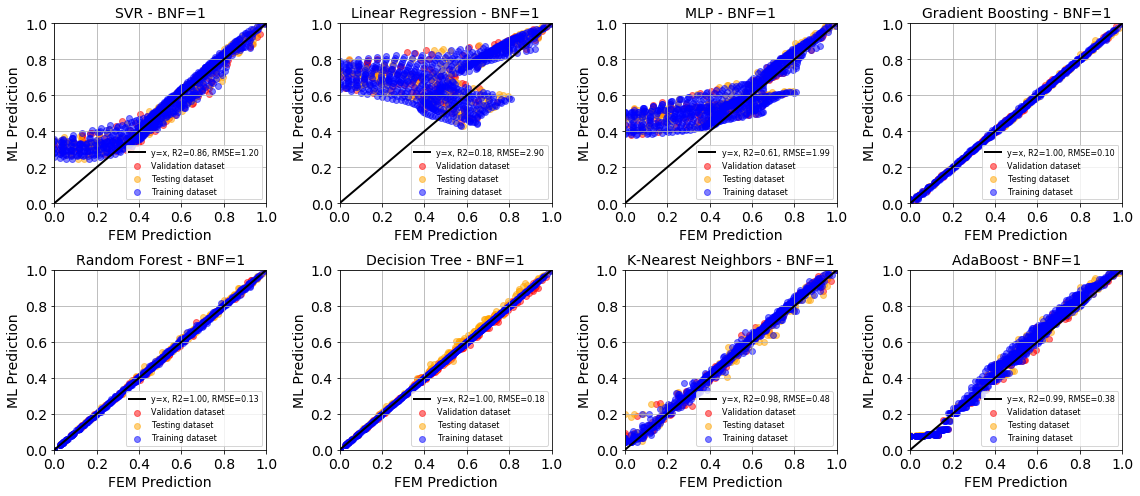

In [8]:
# Define the BNF input (band number)
BNF = 1
BNFinput = f'BNF={BNF}(kHz)'

# Split the data into training, validation, and testing sets
X = df[['k', 'VF(%)', 'a(mm)']] # you can increase features (for more features and increase accurary)
y = df[BNFinput]

# Split data: 70% training, 15% validation, 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create a 2x4 subplot layout
fig, axs = plt.subplots(2, 4, figsize=(16, 7))
axs = axs.ravel()

#labeling subfigures
subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)' ]

# Plot y=x with a red line in all subplots
x_range = np.arange(0, 1.25, 0.25)

# Function to evaluate and plot the predictions
def evaluate_and_plot(predictions, train_predictions, validation_predictions, model_name, ax):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    ax.plot(x_range, x_range, 'k-', linewidth=2)
    ax.scatter(y_val / max(y_val), validation_predictions / max(validation_predictions), alpha=0.5, c='red')
    ax.scatter(y_test / max(y_test), predictions / max(predictions), alpha=0.5, c='orange')
    ax.scatter(y_train / max(y_train), train_predictions / max(train_predictions), alpha=0.5, c='blue')
    ax.set_title(f'{model_name} - BNF={BNF}', fontsize=14)
    ax.set_xlabel('FEM Prediction', fontsize=14)
    ax.set_ylabel('ML Prediction', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend([f'y=x, R2={r2:.2f}, RMSE={rmse:.2f}', 'Validation dataset', 'Testing dataset','Training dataset'], fontsize=8, loc='lower right')
    ax.set_xlim(min(y_train) / max(y_train), 1)
    ax.set_ylim(min(y_train) / max(y_train), 1)
    ax.grid(True)

    print(f'{model_name} Metrics:')
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'R-squared (R2): {r2:.2f}')
    print()

# Train the SVR model
svr = SVR(gamma='auto')
svr.fit(X_train, y_train)
svr_predictions = svr.predict(X_test)
svr_train_predictions = svr.predict(X_train)
svr_val_predictions = svr.predict(X_val) # val
evaluate_and_plot(svr_predictions, svr_train_predictions, svr_val_predictions, 'SVR', axs[0])

# Train the Linear Regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
linear_reg_predictions = linear_reg.predict(X_test)
linear_reg_train_predictions = linear_reg.predict(X_train)
linear_reg_val_predictions = linear_reg.predict(X_val)
evaluate_and_plot(linear_reg_predictions, linear_reg_train_predictions, linear_reg_val_predictions, 'Linear Regression', axs[1])

# Train the MLP model
mlp = MLPRegressor()
mlp.fit(X_train, y_train)
mlp_predictions = mlp.predict(X_test)
mlp_train_predictions = mlp.predict(X_train)
mlp_val_predictions = mlp.predict(X_val) #val
evaluate_and_plot(mlp_predictions, mlp_train_predictions, mlp_val_predictions, 'MLP', axs[2])

# Train the Gradient Boosting Regressor model
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
gb_predictions = gb.predict(X_test)
gb_train_predictions = gb.predict(X_train)
gb_val_predictions = gb.predict(X_val)
evaluate_and_plot(gb_predictions, gb_train_predictions, gb_val_predictions, 'Gradient Boosting', axs[3])

# Train the Random Forest Regressor model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
rf_train_predictions = rf.predict(X_train)
rf_val_predictions = rf.predict(X_val) #val
evaluate_and_plot(rf_predictions, rf_train_predictions, rf_val_predictions, 'Random Forest', axs[4])

# Train the Decision Tree Regressor model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt_predictions = dt.predict(X_test)
dt_train_predictions = dt.predict(X_train)
dt_val_predictions =dt.predict(X_val) #val
evaluate_and_plot(dt_predictions, dt_train_predictions, dt_val_predictions, 'Decision Tree', axs[5])

# Train the K-Nearest Neighbors (KNN) Regressor model
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
knn_train_predictions = knn.predict(X_train)
knn_val_predictions = knn.predict(X_val) #Val
evaluate_and_plot(knn_predictions, knn_train_predictions, knn_val_predictions, 'K-Nearest Neighbors', axs[6])

# Train the AdaBoost Regressor model
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4))
adaboost.fit(X_train, y_train)
adaboost_predictions = adaboost.predict(X_test)
adaboost_train_predictions = adaboost.predict(X_train)
adaboost_val_predictions = adaboost.predict(X_val) #val
evaluate_and_plot(adaboost_predictions, adaboost_train_predictions, adaboost_val_predictions, 'AdaBoost', axs[7])

plt.tight_layout()
plt.show()

# Create a dictionary to store model results
model_results = {
    'Model': [],
    'R2 Score': [],
    'RMSE': [],
    'BNF': []  # Add a column for BNF
}

# Evaluate and append results for each model
models = [svr, linear_reg, mlp, gb, rf, dt, knn, adaboost]
model_names = ['SVR', 'Linear Regression', 'MLP', 'Gradient Boosting', 'Random Forest', 'Decision Tree', 'K-Nearest Neighbors', 'AdaBoost']

for model, name in zip(models, model_names):
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    model_results['Model'].append(name)
    model_results['R2 Score'].append(r2)
    model_results['RMSE'].append(rmse)
    model_results['BNF'].append(BNF)  # Add BNF value

# Create new_df_accuracy DataFrame
new_df_accuracy = pd.DataFrame(model_results)

# Sort the DataFrame by R2 Score in descending order
new_df_accuracy = new_df_accuracy.sort_values(by='R2 Score', ascending=False)

# Save the DataFrame to a CSV file
new_df_accuracy.to_csv('model_accuracy.csv', index=False)
